# Redes neuronales para clasificación de secuencias

Ahora veremos cómo podemos, a partir de una secuencia de datos, inferir a qué clase pertenecen. Para esta tarea vamos a usar nuevamente un RNN del tipo LSTM, pero esta vez con una sola salida.

La tarea que vamos a tener es la siguiente: a partir de menus que proporcionan los restaurantes, clasificar estos restaurantes en una categoría de precios. Vamos a tener cuatro categorías de prcios, donde 1 son los restaurantes más baratos, mientras que 4 son los más caros. 

## Cargar las bibliotecas necesarias

In [23]:
import json

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Activation, SpatialDropout1D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Preparar los datos

Como hemos visto en el ejercicio pasado, debemos cargar los datos. Además será necesario ver cómo su organización 

In [2]:
train_set = list()
dev_set = list()

with open("../data/trainset.json") as F:
    for line in F:
        train_set.append(json.loads(line))
with open("../data/devset.json") as F:
    for line in F:
        dev_set.append(json.loads(line))

print(train_set[1])
print(len(train_set))
print(len(dev_set))

{'rating': '$$', 'name': 'Bin38', 'type': 'american (new)', 'location': 'sf', 'menu': ['bin frittata artisan ham swiss cheese potatoes mixed greens', 'sweet corn fritters wildflower honey whipped butter', 'strawberry eclairs white chocolate mousse hazelnuts', 'grilled cheese on whole wheat fontina smoked mozzarella oven roasted tomatoes arugula basil mayo', 'beef brisket panini fontina oven roasted tomatoes arugula horseradish sauce items marked with served before pm', 'hot beef brisket sandwich creamy horseradish sauce slaw french fries', 'roasted wild mushroom panini fromage blanc gypsy peppers creamy smoked pepper dip', 'house made chicken sausage grilled summer squash basil pesto', 'bacon wrapped sea scallops summer melon herb salad balsamic', 'american artisan cheeses small house made crackers fruit and condiments items marked with served before pm', 'warm marinated olives items marked with served before pm', 'wild mushroom gypsy pepper panini fromage blanc creamy smoked pepper di

In [3]:
train_ratings = list()
train_menus = list()

dev_ratings = list()
dev_menus = list()

dictionary = list()
rating_labels = list()

for restaurant in train_set:
    menu = " . ".join(restaurant["menu"]).split()
    train_menus.append(menu)
    train_ratings.append(len(restaurant["rating"])-1)
    dictionary += menu

for restaurant in dev_set:
    menu = " . ".join(restaurant["menu"]).split()
    dev_menus.append(menu)
    dev_ratings.append(len(restaurant["rating"])-1)

dictionary = list(set(dictionary))
print(train_menus[0][:30])
print(train_ratings[0])
print(len(dictionary))


['squid', 'tofu', 'lunch', 'cooked', 'squid', 'tofu', 'vegetables', 'with', 'seasoned', 'soy', 'sauce', '.', 'edamame', 'broiled', 'green', 'soybeans', '.', 'hotate', 'scallop', '.', 'oyako', 'don', 'dinner', 'chicken', 'vegetables', 'and', 'egg', 'cooked', 'with', 'sweet']
1
44090


Ahora nuevamente convertiremos todas las palabras en enteros y los rankings a varables categóricas

In [5]:
word_to_index = {"PAD":0,"OOV":1, "BOS":2, "EOS":3}
for word in dictionary:
    word_to_index[word] = len(word_to_index)

def sent_to_int(sent):
    int_sent = list()
    for word in sent:
        if word in word_to_index.keys():
            int_sent.append(word_to_index[word])
        else:
            int_sent.append(word_to_index["OOV"])
    return int_sent

train_X, dev_X, train_Y, dev_Y = list(), list(), list(), list()

for lineX, lineY in zip(train_menus, train_ratings):
    train_X.append(sent_to_int(lineX))
    train_Y.append(to_categorical(lineY, num_classes=4))

for lineX, lineY in zip(dev_menus, dev_ratings):
    dev_X.append(sent_to_int(lineX))
    dev_Y.append(to_categorical(lineY, num_classes=4))
    
train_Y = np.asarray(train_Y)
dev_Y = np.asarray(dev_Y)

print(train_X[1])
print(train_Y[1])

[4903, 15682, 26843, 3882, 16306, 12628, 42022, 21190, 24219, 16049, 38922, 28898, 43750, 13101, 14475, 30413, 20431, 16049, 14753, 32559, 34564, 8946, 36535, 7599, 16049, 11846, 12628, 34234, 39138, 32086, 23838, 30379, 4047, 36785, 35049, 32009, 15311, 16832, 270, 16049, 16718, 21119, 22057, 23838, 36785, 35049, 32009, 15311, 7268, 16700, 13511, 40071, 27030, 4625, 11240, 12707, 16049, 17237, 16718, 21119, 23652, 6397, 7268, 16700, 8179, 5259, 16992, 16049, 35049, 18407, 1825, 22057, 30288, 7283, 39181, 4313, 6397, 30379, 40291, 18445, 16049, 38227, 30685, 36893, 32642, 11846, 11445, 23405, 16832, 42803, 16049, 16973, 41524, 310, 41274, 11445, 7741, 18926, 20118, 10556, 16049, 10302, 26843, 26261, 19809, 38227, 30685, 844, 16740, 12152, 20160, 13511, 40071, 27030, 4625, 11240, 12707, 16049, 7953, 2116, 42744, 13511, 40071, 27030, 4625, 11240, 12707, 16049, 18407, 1825, 39181, 40291, 22057, 30288, 7283, 6397, 30379, 40291, 18445, 13511, 40071, 27030, 4625, 11240, 12707, 16049, 11846, 

Limitaremos el tamaño de las entradas a 200 palabras, dada la gran variabilidad de los menus encontrados.

In [6]:
MAX_LENGTH = 300
train_X = pad_sequences(maxlen=MAX_LENGTH, sequences=train_X, padding="post")
dev_X = pad_sequences(maxlen=MAX_LENGTH, sequences=dev_X, padding="post")

print(train_X[1])


[16832 42803 16049 16973 41524   310 41274 11445  7741 18926 20118 10556
 16049 10302 26843 26261 19809 38227 30685   844 16740 12152 20160 13511
 40071 27030  4625 11240 12707 16049  7953  2116 42744 13511 40071 27030
  4625 11240 12707 16049 18407  1825 39181 40291 22057 30288  7283  6397
 30379 40291 18445 13511 40071 27030  4625 11240 12707 16049 11846 11445
 23405 16946 12628 16832 42803 11922 16049 40173 31291  4228 23549 34553
 16049 42083 36297 35049 18109 16306 22057 39138 40268 43044 31508 16049
 38227 30685 35637 32642 16735 35471 20118 39138 40268 43044 16049  8534
 18109   827 41424 35795 32742 19402 16700 16049 18504 32009 17005 16946
 12628 15311  9280 12729 34534 16049  4903 21190 23691 13511 40071 27030
  4625 11240 12707 16049 28753 36999 20118 39347 12107 24888 16875 37348
 15649  7283 34534 13511 40071 27030  4625 11240 12707 16049 10302 26843
 26261 12395 38227 30685   844 16740 12152 20160 13511 40071 27030  4625
 11240 12707 16049 42111 43760  8946 41571 30413  5

## Definir el modelo y entrenar con LSTM

Ahora definimos nuestra red. Veamamos ahora que configuraremos algunos hyperparámetros adicionales en el optimizador, ademas de usar Adam esta vez.

In [25]:
EMBEDDING_SIZE = 50
EPOCHS = 50
BATCH_SIZE = 32
HIDDEN_LAYER_SIZE = 200
DROPOUT = 0.2

model = Sequential()
model.add(Embedding(len(word_to_index), EMBEDDING_SIZE, input_length=MAX_LENGTH))
model.add(SpatialDropout1D(DROPOUT))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=DROPOUT, recurrent_dropout=DROPOUT))
model.add(Dense(4))
model.add(Activation("sigmoid"))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy",])

Y la entrenamos. Dado que el entrenamiento será largo, vamos a utilizar una opción llamada parada temprana o early stopping. Básicamente lo que hace es parar el entrenamiento cuando no se logre mejorar el costo en un cierto periodo de épocas. Ese periodo de épocas es llamado paciencia (patience).

In [27]:
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=20)
model_save = ModelCheckpoint('best_classification.hdf5', save_best_only=True, monitor='val_accuracy', mode='min')

history = model.fit(train_X, train_Y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(dev_X, dev_Y), callbacks=[es, model_save])

Train on 4860 samples, validate on 607 samples
Epoch 1/50
4860/4860 [==============================] - 38s 8ms/sample - loss: 0.5820 - accuracy: 0.7479 - val_loss: 0.9629 - val_accuracy: 0.6392
Epoch 2/50
4860/4860 [==============================] - 38s 8ms/sample - loss: 0.5612 - accuracy: 0.7613 - val_loss: 0.9407 - val_accuracy: 0.6079
Epoch 3/50
4860/4860 [==============================] - 38s 8ms/sample - loss: 0.5055 - accuracy: 0.7842 - val_loss: 0.9792 - val_accuracy: 0.6409
Epoch 4/50
4860/4860 [==============================] - 38s 8ms/sample - loss: 0.4678 - accuracy: 0.8049 - val_loss: 0.9990 - val_accuracy: 0.6178
Epoch 5/50
4860/4860 [==============================] - 38s 8ms/sample - loss: 0.4434 - accuracy: 0.8056 - val_loss: 1.0074 - val_accuracy: 0.6376
Epoch 6/50
4860/4860 [==============================] - 38s 8ms/sample - loss: 0.4136 - accuracy: 0.8272 - val_loss: 1.0699 - val_accuracy: 0.6606
Epoch 7/50
4860/4860 [==============================] - 38s 8ms/sample 

## Resultados

Ahora veamos el comportamiento del entrenamiento a travéz de las épocas.

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')


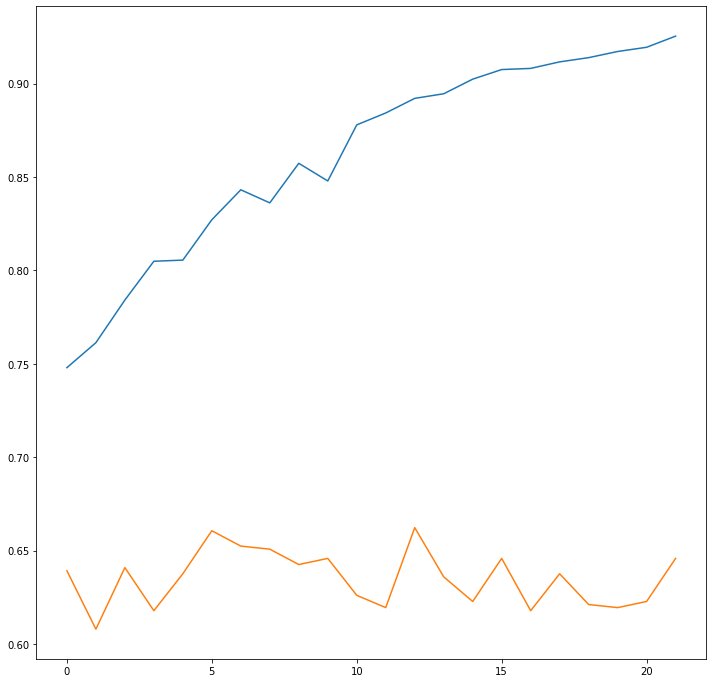

In [28]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
print(hist.keys())
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

Y guardamos el modelo

In [ ]:
model.save("Models/restaurant_classification.h5")

## Ejercicio

Hemos visto cómo usar un LSTM para entrenar un modelo que nos permite clasificar un texto. Sin embargo, el set de datos con el que contamos incluye información complementaria: cómo tipo de restaurante y localización del mismo. Es hora de integrar estos datos para mejorar el rendimiento del modelo. 

* ¿Cuál sería la mejor forma de integrar estos datos al modelo?
* Implemente una solución y demuestre que su modelo mejora al LSTM simple.
* ¿Tiene alguna otra idea de cómo mejorar el rendimiento del modelo?